# Documentation
**Spencer Ressel**

*2023.01.17*

***

This script is a compilation of functions that serve to recreate the figures of 
two papers, Wheeler and Hendon (2004) and Jiang et al. (2020).
The Wheeler and Hendon (2004) paper describes the creation of a real-time multivariate
MJO index (RMM), and splits the MJO into 8 phases based on the RMM index. 
The Jiang et al. (2020) paper is a broad overview of the MJO,
where the specific figure (Fig. 1) recreated is a composite of MJO-associated rainfall
anomalies during boreal winter for each MJO phase.

***

## Inputs:       
### Global 2.5° x 2.5° resolution, daily timeseries in netCDF format:
* precipitation from TRMM
* outgoing longwave radiation (OLR) data from Liebmann and Smith (1996)
* 200 hPa zonal and meridional wind from ERA5 reanalysis
* 850 hPa zonal and meridional wind from ERA5 reanalysis
                
## Dependencies: 
* mjo_mean_state_diagnostics.py

# Imports

In [2]:
# Data processing tools
import numpy as np
import scipy
import scipy.signal as signal
import xarray as xr
import mjo_mean_state_diagnostics as mjo

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap


# Seaborn
import seaborn as sns

# Set Physical Constants and Analysis Parameters

In [3]:
# Set time bounds
TIME_MIN = '1979-01-01T00:00:00.000000000'
TIME_MAX = '2018-12-31T00:00:00.000000000'
SAMPLING_FREQUENCY = 1

# Set latitude bounds
LATITUDE_SOUTH = -25
LATITUDE_NORTH = 25

# Set central longitude
CENTRAL_LONGITUDE = 160

# Set longitude bounds
LONGITUDE_MIN = -180
LONGITUDE_MAX = 180

# Cut-off periods for intraseasonal filtering
INTRASEASONAL_LOWCUT = 100
INTRASEASONAL_HIGHCUT = 20

# Seconds per day
SECONDS_PER_DAY = 24 * 3600

# Load Data

In [4]:
# TRMM Precipitation
data_directory_precip = r"/home/disk/eos7/sressel/Research/Data/NASA/TRMM/"
file_name_precip = r"trmm_precipitation_daily_1998_2018.nc"
data_precipitation = xr.open_dataset(
    data_directory_precip + file_name_precip, engine="netcdf4"
)
precipitation = data_precipitation['prec']

# NASA OLR (Liebmann and Smith 1996)
data_directory_olr = r"/home/disk/eos7/sressel/Research/Data/NOAA/"
file_name_olr = r"olr.day.mean.nc"
data_olr = xr.open_dataset(data_directory_olr + file_name_olr, engine="netcdf4")
outgoing_longwave_radiation = data_olr['olr']

# Wind 
data_directory_wind = r"/home/disk/eos7/sressel/Research/Data/ECMWF/ERA5/"
file_name_wind = r"era5_combined_wind_daily_1979_2020_pressure_levels.nc"
wind_data = xr.open_dataset(data_directory_wind + file_name_wind, engine='netcdf4')

# Upper and lower level zonal wind
upper_level_zonal_wind = wind_data['u'].sel(lev=200)
lower_level_zonal_wind = wind_data['u'].sel(lev=850)

# Upper and lower level zonal wind
upper_level_meridional_wind = wind_data['v'].sel(lev=200)
lower_level_meridional_wind = wind_data['v'].sel(lev=850)

time = outgoing_longwave_radiation.time
latitude = outgoing_longwave_radiation.lat
longitude = outgoing_longwave_radiation.lon

variables_dict = {
    # 'precipitation' : precipitation,
    'outgoing longwave radiation' : outgoing_longwave_radiation,
    'upper level zonal wind' : upper_level_zonal_wind,
    'lower level zonal wind' : lower_level_zonal_wind,
    'upper level meridional wind' : upper_level_meridional_wind,
    'lower level meridional wind' : lower_level_meridional_wind,
}

In [7]:
outgoing_longwave_radiation['time']

<xarray.DataArray 'time' (time: 17267)>
array(['1974-06-01T00:00:00.000000000', '1974-06-02T00:00:00.000000000',
       '1974-06-03T00:00:00.000000000', ..., '2021-09-06T00:00:00.000000000',
       '2021-09-07T00:00:00.000000000', '2021-09-08T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1974-06-01 1974-06-02 ... 2021-09-08
Attributes:
    long_name:      Time
    delta_t:        0000-00-01 00:00:00
    standard_name:  time
    axis:           T
    actual_range:   [1528872. 1943256.]

# Process Data

Detrend the data, remove the annual cycle and the first three harmonics (seasonal cycle), and filter the data on intraseasonal timescales

## Subset Data
Specifically select the data from times of interest and from tropical latitudes

In [4]:
variables_subset = {}

for variable in variables_dict:
    variables_subset[variable] = variables_dict[variable].sel(
        time=slice(TIME_MIN, TIME_MAX),
        lat=slice(LATITUDE_NORTH, LATITUDE_SOUTH)
    )

### Plot

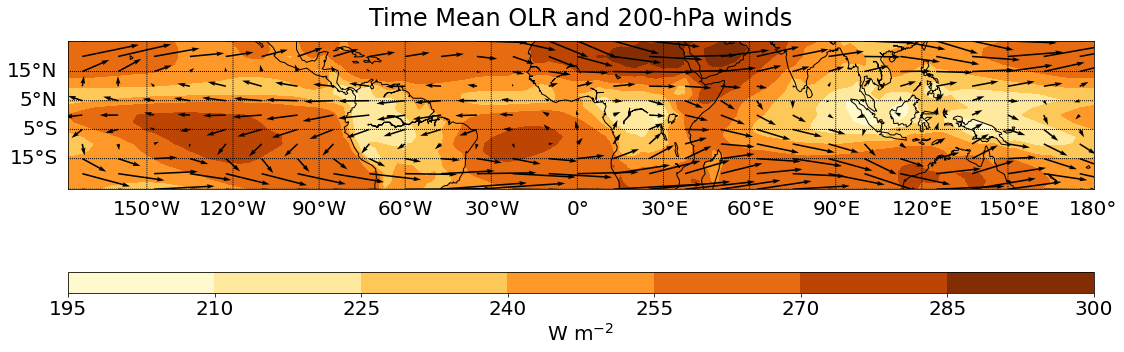

In [5]:
[longitude_mesh, latitude_mesh] = np.meshgrid(
    variables_subset['outgoing longwave radiation'].lon, 
    variables_subset['outgoing longwave radiation'].lat)

plt.rcParams.update({'font.size':20})
[fig, ax] = plt.subplots(1, 1, figsize=(16, 16))

# Moisture Tendency
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = -177.5, urcrnrlon = 180,
            ax=ax)
m.drawcoastlines()

ax.set_title('Time Mean OLR and 200-hPa winds', pad =15)
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    variables_subset['outgoing longwave radiation'].mean(dim='time'),
    cmap='YlOrBr',
    latlon=True,
)
cbar0 = fig.colorbar(cf, ax=ax, aspect=50, pad=0.075, orientation='horizontal')
cbar0.set_label(r'W m$^{-2}$')

m.quiver(
    longitude_mesh[::2,::5],
    latitude_mesh[::2,::5],
    variables_subset['upper level zonal wind'].mean(dim='time')[::2,::5],
    variables_subset['upper level meridional wind'].mean(dim='time')[::2,::5],
    latlon=True,
    width=0.0015
)

# Add gridlines
parallels = np.arange(-25,25,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], color='black', alpha=1)
meridians = np.arange(-180.,180.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True], color='black', alpha=1)

plt.tight_layout()
plt.show()

## Remove mean & Detrend the data

In [6]:
variables_detrended = {}

for variable in variables_dict:
    variables_detrended[variable] = variables_subset[variable].copy(deep=True)
    variables_detrended[variable].values = variables_detrended[variable] - variables_detrended[variable].mean(dim='time')
    
    variables_detrended[variable].values = signal.detrend(
                                               variables_subset[variable], 
                                               axis=0, 
                                               type='linear'
                                           )

## Remove the Annual Cycle

In [7]:
variables_deannualized = {}
variables_annual_cycle = {}

for variable in variables_dict:
    variables_deannualized[variable] = variables_detrended[variable].copy(deep=True)
    variables_annual_cycle[variable] = variables_detrended[variable].copy(deep=True)
    
    [           
        variables_deannualized[variable].values,
        variables_annual_cycle[variable].values,
    ] = mjo.remove_annual_cycle_matrix(
        variables_detrended[variable], 
        time = variables_detrended[variable].time.values,
        lat =  variables_detrended[variable].lat.values,
        lon =  variables_detrended[variable].lon.values
    )    

## Filter Data 

Temporally filter the data on intraseasonal (20-100 day) timescales, using a Lanczos filter

In [8]:
variables_filtered = {}

for variable in variables_dict:
    variables_filtered[variable] = variables_deannualized[variable].copy(deep=True)
    variables_filtered[variable].values = mjo.lanczos_bandpass_filter(
        variables_deannualized[variable],
        lowcut = INTRASEASONAL_LOWCUT,
        highcut = INTRASEASONAL_HIGHCUT,
        fs=1,
        filter_axis=0,
    )

### Plot MJO-filtered data

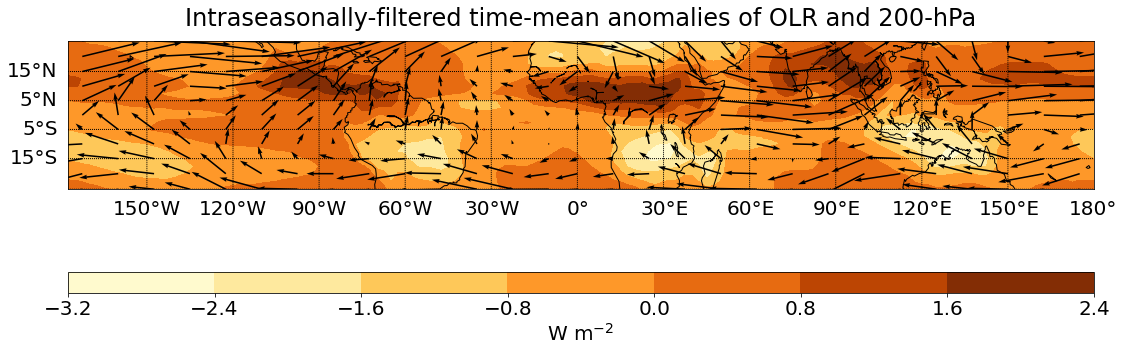

In [9]:
[longitude_mesh, latitude_mesh] = np.meshgrid(
    variables_filtered['outgoing longwave radiation'].lon, 
    variables_filtered['outgoing longwave radiation'].lat)

plt.rcParams.update({'font.size':20})
[fig, ax] = plt.subplots(1, 1, figsize=(16, 16))

# Moisture Tendency
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = -177.5, urcrnrlon = 180,
            ax=ax)
m.drawcoastlines()

ax.set_title('Intraseasonally-filtered time-mean anomalies of OLR and 200-hPa', pad =15)
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    variables_filtered['outgoing longwave radiation'].mean(dim='time'),
    cmap='YlOrBr',
    latlon=True,
)
cbar0 = fig.colorbar(cf, ax=ax, aspect=50, pad=0.075, orientation='horizontal')
cbar0.set_label(r'W m$^{-2}$')

m.quiver(
    longitude_mesh[::2,::5],
    latitude_mesh[::2,::5],
    variables_filtered['upper level zonal wind'].mean(dim='time')[::2,::5],
    variables_filtered['upper level meridional wind'].mean(dim='time')[::2,::5],
    latlon=True,
    width=0.0015
)

# Add gridlines
parallels = np.arange(-25,25,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], color='black', alpha=1)
meridians = np.arange(-180.,180.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True], color='black', alpha=1)

plt.tight_layout()
plt.show()

## Select Boreal Winter 

In [10]:
boreal_winter_months = [11,12,1,2,3,4]

variables_boreal_winter = {}

for variable in variables_dict:
    variables_boreal_winter[variable] = variables_filtered[variable].sel(time=
        variables_filtered[variable]['time.month'].isin(boreal_winter_months)
    )
        

## Average across latitude

In [11]:
variables_meridional_average = {}

for variable in variables_dict:
    variables_meridional_average[variable] = variables_filtered[variable].copy(deep=True).mean(dim='lat')

## Standardize time series

In [12]:
variables_standardized = {}

for variable in variables_dict:
    variables_standardized[variable] = variables_meridional_average[variable].copy(deep=True)
    variables_standardized[variable].values = (
        (
            variables_meridional_average[variable] - variables_meridional_average[variable].mean(dim='time')
        ) / variables_meridional_average[variable].std(dim='time')
    )

## Concatenate OLR with zonal winds

In [13]:
combined_data = np.concatenate(
    [
        variables_standardized['outgoing longwave radiation'],
        variables_standardized['upper level zonal wind'],
        variables_standardized['lower level zonal wind'],
    ],
    axis=1,
)
combined_data.shape
len(variables_subset['outgoing longwave radiation'].time)

14610

## Compute EOFs

In [14]:

#### Calculate EOFs and PCs
[
    mjo_EOF,
    mjo_PC,
    mjo_eigval,
    mjo_eigval_explained_var,
    mjo_eigval_err,
    mjo_dof,
    mjo_phi_0,
    mjo_phi_L,
] = mjo.eof(combined_data.T)

# Extract the EOFs of each variable from the array
olr_EOF = mjo_EOF[:, : len(outgoing_longwave_radiation.lon)]
upper_level_zonal_wind_EOF = mjo_EOF[:, len(outgoing_longwave_radiation.lon) : 2 * len(outgoing_longwave_radiation.lon)]
lower_level_zonal_wind_EOF = mjo_EOF[:, 2 * len(outgoing_longwave_radiation.lon) :]

# Convert the principal components to an RMM-like index
RMM1 = mjo_PC[0] / np.std(mjo_PC[0])
RMM2 = -mjo_PC[1] / np.std(mjo_PC[1])
mjo_strength = np.sqrt(RMM1 ** 2 + RMM2 ** 2)

# Remove weak MJO events
RMM1[mjo_strength < 1] = 0
RMM2[mjo_strength < 1] = 0


In [397]:
mjo_PC.shape

(432, 14610)

In [15]:

#### Calculate phases
def compute_mjo_phase_indices(RMM1, RMM2):
    phase_indices = {}
    # Find all of the points in phase 1
    phase_indices[1] = np.squeeze(
        np.where((RMM1 < 0) & (RMM2 < 0) & (np.abs(RMM1) > np.abs(RMM2)))
    )

    # Phase 2
    phase_indices[2] = np.squeeze(
        np.where((RMM1 < 0) & (RMM2 < 0) & (np.abs(RMM1) < np.abs(RMM2)))
    )

    # Phase 3
    phase_indices[3] = np.squeeze(
        np.where((RMM1 > 0) & (RMM2 < 0) & (np.abs(RMM1) < np.abs(RMM2)))
    )

    # Phase 4
    phase_indices[4] = np.squeeze(
        np.where((RMM1 > 0) & (RMM2 < 0) & (np.abs(RMM1) > np.abs(RMM2)))
    )

    # Phase 5
    phase_indices[5] = np.squeeze(
        np.where((RMM1 > 0) & (RMM2 > 0) & (np.abs(RMM1) > np.abs(RMM2)))
    )

    # Phase 6
    phase_indices[6] = np.squeeze(
        np.where((RMM1 > 0) & (RMM2 > 0) & (np.abs(RMM1) < np.abs(RMM2)))
    )

    # Phase 7
    phase_indices[7] = np.squeeze(
        np.where((RMM1 < 0) & (RMM2 > 0) & (np.abs(RMM1) < np.abs(RMM2)))
    )

    # Phase 8
    phase_indices[8] = np.squeeze(
        np.where((RMM1 < 0) & (RMM2 > 0) & (np.abs(RMM1) > np.abs(RMM2)))
    )

    return phase_indices


phase_indices = compute_mjo_phase_indices(RMM1, RMM2)


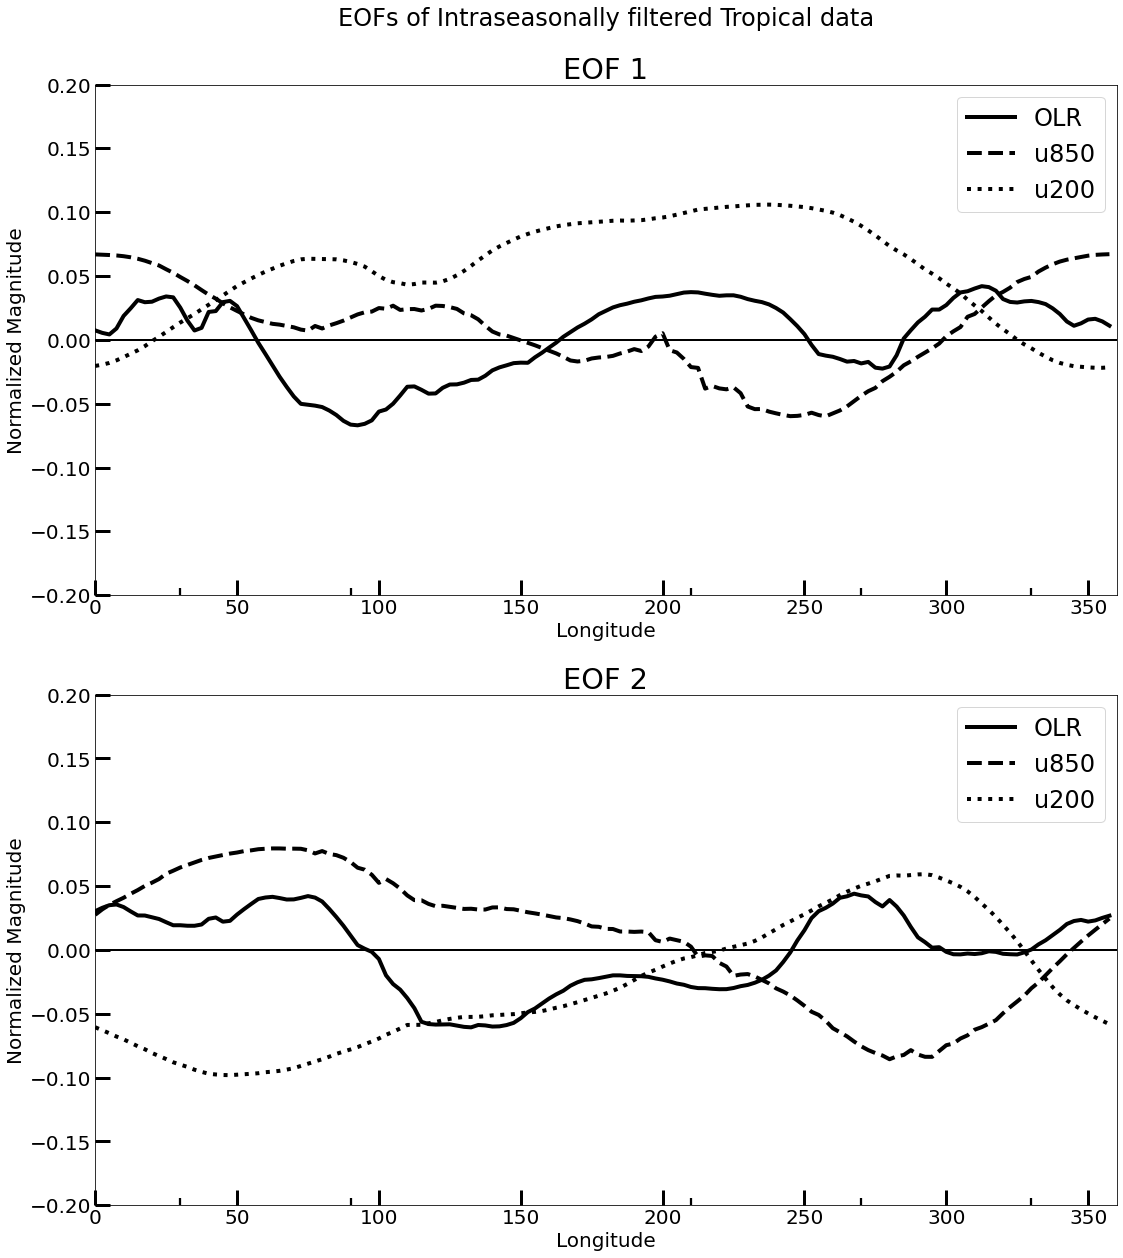

In [16]:
#%% Plotting
#### EOFs as a function of latitude
[fig, ax] = plt.subplots(2, 1, figsize=(32,18))
fig.suptitle("EOFs of Intraseasonally filtered Tropical data")
plt.rcParams.update({"font.size": 24})
longitude = outgoing_longwave_radiation.lon

# EOF 1
ax[0].plot(longitude, -olr_EOF[0], color="k", lw=4, label="OLR")
ax[0].plot(
    longitude, lower_level_zonal_wind_EOF[0], ls="--", color="k", lw=4, label="u850"
)
ax[0].plot(
    longitude, upper_level_zonal_wind_EOF[0], ls=":", color="k", lw=4, label="u200"
)
ax[0].axhline(y=0, lw=2, color="k")

# Set axis labels and limits
ax[0].set_title("EOF 1")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Normalized Magnitude")
ax[0].set_xlim(0, 360)
ax[0].set_ylim(-0.2, 0.2)
ax[0].set_aspect(360 / 0.8)

# Specify tick parameters
# lon_formatter = LongitudeFormatter()
# ax[0].xaxis.set_major_formatter(lon_formatter)
# ax[0].xaxis.set_major_locator(mticker.FixedLocator([0, 60, 120, 180, 240, 300, 360]))
ax[0].tick_params(which="major", width=3 * 1.00, length=3 * 5, direction="in")
ax[0].xaxis.set_minor_locator(mticker.FixedLocator([30, 90, 150, 210, 270, 330]))
ax[0].tick_params(which="minor", width=3 * 0.75, length=3 * 2.5, direction="in")

ax[0].legend(loc="upper right")

# EOF 2
ax[1].plot(longitude, olr_EOF[1], color="k", lw=4, label="OLR")
ax[1].plot(
    longitude, -lower_level_zonal_wind_EOF[1], ls="--", color="k", lw=4, label="u850"
)
ax[1].plot(
    longitude, -upper_level_zonal_wind_EOF[1], ls=":", color="k", lw=4, label="u200"
)
ax[1].axhline(y=0, lw=2, color="k")

# Set axis labels and limits
ax[1].set_title("EOF 2")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Normalized Magnitude")
ax[1].set_xlim(0, 360)
ax[1].set_ylim(-0.2, 0.2)
ax[1].set_aspect(360 / 0.8)

# Specify tick parameters
# lon_formatter = LongitudeFormatter()
# ax[1].xaxis.set_major_formatter(lon_formatter)
# ax[1].xaxis.set_major_locator(mticker.FixedLocator([0, 60, 120, 180, 240, 300, 360]))
ax[1].tick_params(which="major", width=3 * 1.00, length=3 * 5, direction="in")
ax[1].xaxis.set_minor_locator(mticker.FixedLocator([30, 90, 150, 210, 270, 330]))
ax[1].tick_params(which="minor", width=3 * 0.75, length=3 * 2.5, direction="in")

ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

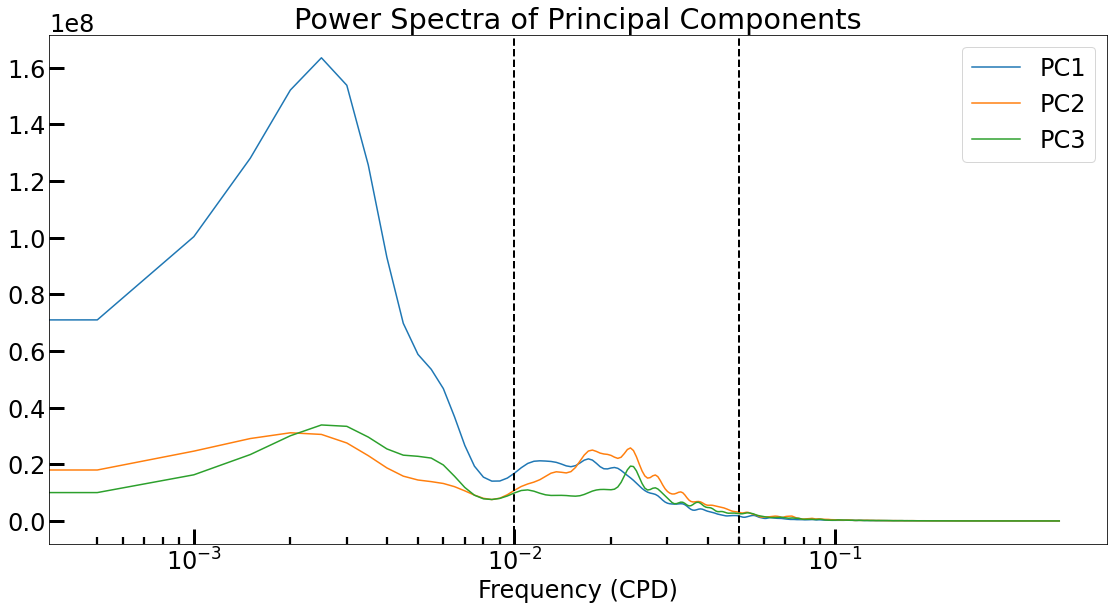

In [17]:
SEGMENT_LENGTH = 2000
OVERLAP = 1000
scaling_mode = "density"

frequency = {}
spectrum = {}
area = {}
scaling_factor = {}

for i in range(1, 4):
    (frequency[i], spectrum[i]) = signal.welch(
        mjo_PC[i - 1] - np.mean(mjo_PC[i - 1]),
        fs=(1 / (SECONDS_PER_DAY)),
        window="hann",
        nperseg=SEGMENT_LENGTH,
        noverlap=OVERLAP,
        scaling=scaling_mode,
    )
    area[i] = scipy.integrate.trapz(spectrum[i], x=frequency[i])
    scaling_factor[i] = (mjo_eigval_explained_var[i - 1]) / area[i]
# Smooth each of the spectra
kernel = np.array([0.25, 0.5, 0.25])  # 1-2-1 filter for smoothing
for k in range(8):
    for i in spectrum:
        spectrum[i] = np.convolve(spectrum[i], kernel, mode="same")
# Plot the power spectra
[fig, ax] = plt.subplots(figsize=(16,9))
ax.set_title("Power Spectra of Principal Components")
for i in spectrum:
    ax.plot(
        SECONDS_PER_DAY * frequency[i],
        scaling_factor[i] * spectrum[i],
        label=("PC" + str(i)),
    )
# Add vertical lines at the frequencies 0.01 and 0.05
ax.axvline(x=0.01, color="black", ls="--", lw=2)
ax.axvline(x=0.05, color="black", ls="--", lw=2)

# Format x-axos
ax.set_xlabel("Frequency (CPD)")
ax.set_xscale("log")
ax.xaxis.set_major_locator(mticker.FixedLocator([10 ** -3, 10 ** -2, 10 ** -1]))
ax.tick_params(which="major", width=3 * 1.00, length=3 * 5, direction="in")
ax.xaxis.set_minor_locator(
    mticker.FixedLocator(
        [
            0.0005,
            0.0006,
            0.0007,
            0.0008,
            0.0009,
            0.001,
            0.002,
            0.003,
            0.004,
            0.005,
            0.006,
            0.007,
            0.008,
            0.009,
            0.02,
            0.03,
            0.04,
            0.05,
            0.06,
            0.07,
            0.08,
            0.09,
        ]
    )
)
ax.tick_params(which="minor", width=3 * 0.75, length=3 * 2.5, direction="in")

ax.legend(loc="best")

plt.tight_layout()
plt.show()

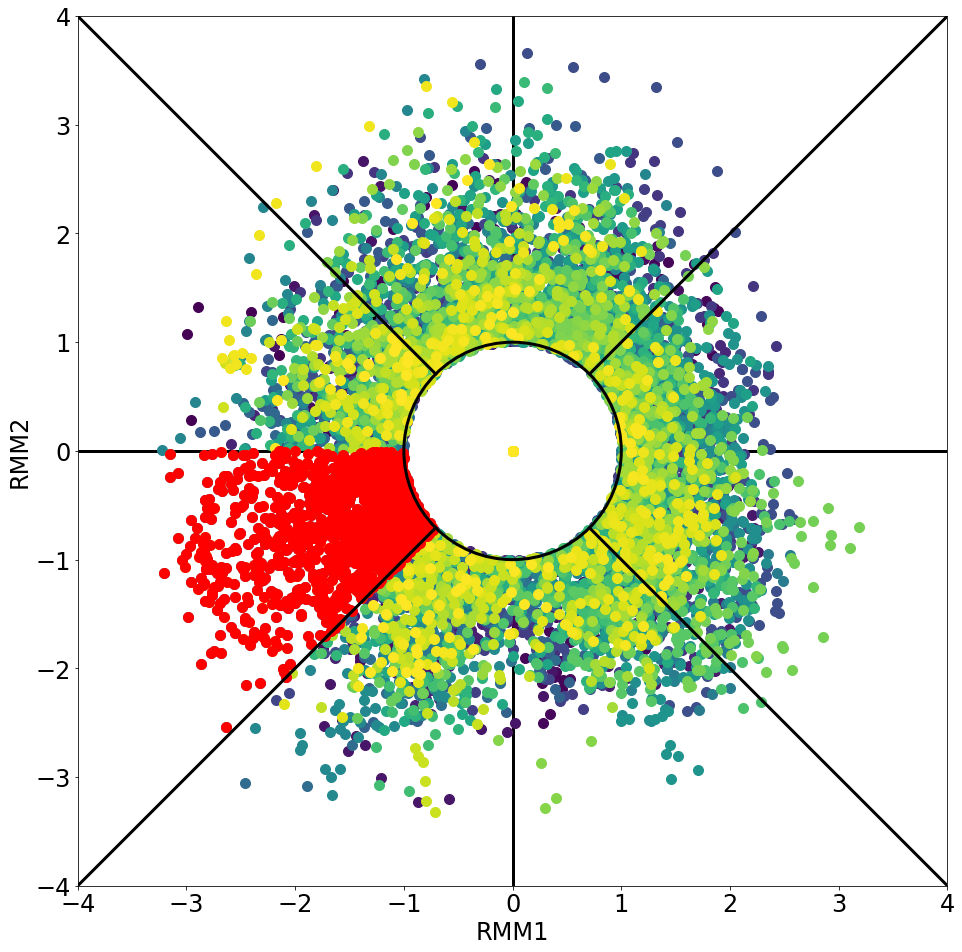

In [18]:
# Configure plot
[fig, ax] = plt.subplots(figsize=(16,16))
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 3
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
plt.xlabel("RMM1")
plt.ylabel("RMM2")
ax.set_facecolor("white")

# Plot index points
colormap = sns.color_palette("viridis", as_cmap=True)
start_index = 0
end_index = len(RMM1) - 1
ax.plot(RMM1[start_index], RMM2[start_index], color="black", marker=".", ls="-", ms=30)
for i in range(start_index + 1, end_index + 1):
    ax.plot(
        RMM1[i],
        RMM2[i],
        color=colormap((i - start_index) / (end_index - start_index)),
        marker="o",
        ms=10,
    )
ax.plot(
    RMM1[phase_indices[1]],
    RMM2[phase_indices[1]],
    color="red",
    marker="o",
    ms=10,
    ls="",
)
# Add phase regions overlay
circle1 = plt.Circle((0, 0), 1.0, color="k", fill=False, lw=3, zorder=10)
ax.hlines(y=0, xmin=-4, xmax=-1, color="k", lw=3, ls="-")
ax.hlines(y=0, xmin=1, xmax=4, color="k", lw=3, ls="-")
ax.vlines(x=0, ymin=-4, ymax=-1, color="k", lw=3, ls="-")
ax.vlines(x=0, ymin=1, ymax=4, color="k", lw=3, ls="-")
ax.plot([np.sqrt(2) / 2, 4], [np.sqrt(2) / 2, 4], color="k", lw=3, ls="-")
ax.plot([np.sqrt(2) / 2, 4], [-np.sqrt(2) / 2, -4], color="k", lw=3, ls="-")
ax.plot([-4, -np.sqrt(2) / 2], [4, np.sqrt(2) / 2], color="k", lw=3, ls="-")
ax.plot([-4, -np.sqrt(2) / 2], [-4, -np.sqrt(2) / 2], color="k", lw=3, ls="-")
ax.add_patch(circle1)

ax.set_aspect("equal")
